In [2]:
import pandas as pd
import numpy as np
import time
import math
# Pandarallelの準備
from pandarallel import pandarallel
pandarallel.initialize()

#PRED_FILES = ["gcbert.pred", "codet5_old.pred", "codebert.pred"]
PRED_FILES = ["gcbert.pred", "codet5.pred", "codebert.pred"]
DATA_DIR = "./raw_data/"
COMMENT_FILE= "data.comment"
SOURCE_FILE = "data.source"
TARGET_FILE = "data.target"

COMMENT_PATHS = f"{DATA_DIR}{COMMENT_FILE}"
DATA_SOURCE_PATH = f"{DATA_DIR}{SOURCE_FILE}"
DATA_TARGET_PATH = f"{DATA_DIR}{TARGET_FILE}"
PRED_FULL_PATHS = [f"{DATA_DIR}{f}" for f in PRED_FILES]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
# read file per line and return dataframe and column name is filepath
def read_file_per_line(path):
    with open(path, "r") as f:
        lines = f.readlines()
        lines = [l.rstrip() for l in lines]
        return pd.DataFrame(lines, columns=[path.split("/")[-1]])
# read all files and combine them and return dataframe
def read_files(paths):
    dfs = [read_file_per_line(p) for p in paths]
    return pd.concat(dfs, axis=1)

dfs = read_files([DATA_SOURCE_PATH, DATA_TARGET_PATH, COMMENT_PATHS, *PRED_FULL_PATHS, ] )
dfs.to_excel("./data/data.xls", index=False)

/var/folders/c0/b2qqsnx935n275qlt_fqz8300000gn/T/ipykernel_97942/3077703939.py:13: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  dfs.to_excel("./data/data.xls", index=False)


In [4]:
# add columns for is_correct between target and pred columns
def add_is_correct_column(df, pred_col):
    df[f"is_correct_{pred_col}"] = (df[TARGET_FILE] == df[pred_col])
    print(f"EMScore of {pred_col} is {df[f'is_correct_{pred_col}'].sum() / len(df)}")
    return df
for pred_col in PRED_FILES:
    
    dfs = add_is_correct_column(dfs, pred_col)


EMScore of gcbert.pred is 0.10296684118673648
EMScore of codet5.pred is 0.04712041884816754
EMScore of codebert.pred is 0.09307737056428156


In [5]:
# calc is_correct between each preds
def add_is_correct_between_preds(df):
    for pred_col in PRED_FILES:
        for pred_col2 in PRED_FILES:
            if pred_col == pred_col2:
                continue
            df[f"em_{pred_col}_and_{pred_col2}"] =  (df[pred_col] == df[pred_col2])
            print(f"EMScore of {pred_col} and {pred_col2} is {df[f'em_{pred_col}_and_{pred_col2}'].sum() / len(df)}")
    return df
dfs = add_is_correct_between_preds(dfs)

EMScore of gcbert.pred and codet5.pred is 0.33740546829552065
EMScore of gcbert.pred and codebert.pred is 0.43339150668993603
EMScore of codet5.pred and gcbert.pred is 0.33740546829552065
EMScore of codet5.pred and codebert.pred is 0.3228621291448517
EMScore of codebert.pred and gcbert.pred is 0.43339150668993603
EMScore of codebert.pred and codet5.pred is 0.3228621291448517


In [6]:
# add columns of all_correct for all is_correct columns
def add_all_correct_column(df):
    df["all_correct"] = df[[f"is_correct_{pred_col}" for pred_col in PRED_FILES]].all(axis=1)
    print("Number of all_correct: ", df["all_correct"].sum())
    return df
dfs = add_all_correct_column(dfs)
dfs[dfs["all_correct"]].loc[:,["data.source", "data.target", "data.comment"]].to_excel("./data/all_correct.xls", index=False)

dfs["is_correct_only_gcbert"] = dfs["is_correct_gcbert.pred"] & ~dfs["is_correct_codet5.pred"] & ~dfs["is_correct_codebert.pred"]
dfs[dfs["is_correct_only_gcbert"] ].loc[:,["data.source", "data.target", "data.comment", "codebert.pred", "codet5.pred"]].to_excel("./data/is_correct_only_gcbert.xls", index=False)
print("Sum of correct only gcbert: " + str(sum(dfs["is_correct_only_gcbert"])))
dfs["is_correct_only_codet5"] = dfs["is_correct_codet5.pred"] & ~dfs["is_correct_gcbert.pred"] & ~dfs["is_correct_codebert.pred"]
dfs[dfs["is_correct_only_codet5"] ].loc[:,["data.source", "data.target", "data.comment", "codebert.pred", "gcbert.pred"]].to_excel("./data/is_correct_only_codet5.xls", index=False)
print("Sum of correct only codet5: " + str(sum(dfs["is_correct_only_codet5"])))
dfs["is_correct_only_codebert"] = dfs["is_correct_codebert.pred"] & ~dfs["is_correct_codet5.pred"] & ~dfs["is_correct_gcbert.pred"]
dfs[dfs["is_correct_only_codebert"] ].loc[:,["data.source", "data.target", "data.comment", "codet5.pred", "gcbert.pred"]].to_excel("./data/is_correct_only_codebert.xls", index=False)
print("Sum of correct only codebert: " + str(sum(dfs["is_correct_only_codebert"])))

dfs["is_incorrect_only_gcbert"] = ~dfs["is_correct_gcbert.pred"] & dfs["is_correct_codet5.pred"] & dfs["is_correct_codebert.pred"]
dfs[dfs["is_incorrect_only_gcbert"] ].loc[:,["data.source", "data.target", "data.comment", "gcbert.pred"]].to_excel("./data/is_incorrect_only_gcbert.xls", index=False)
print("Sum of incorrect only gcbert: " + str(sum(dfs["is_incorrect_only_gcbert"])))

dfs["is_incorrect_only_codet5"] = dfs["is_correct_gcbert.pred"] & ~dfs["is_correct_codet5.pred"] & dfs["is_correct_codebert.pred"]
dfs[dfs["is_incorrect_only_codet5"] ].loc[:,["data.source", "data.target", "data.comment", "codet5.pred"]].to_excel("./data/is_incorrect_only_codet5.xls", index=False)
print("Sum of incorrect only codet5: " + str(sum(dfs["is_incorrect_only_codet5"])))

dfs["is_incorrect_only_codebert"] = dfs["is_correct_gcbert.pred"] & dfs["is_correct_codet5.pred"] & ~dfs["is_correct_codebert.pred"]
dfs[dfs["is_incorrect_only_codebert"] ].loc[:,["data.source", "data.target", "data.comment", "codebert.pred"]].to_excel("./data/is_incorrect_only_codebert.xls", index=False)
print("Sum of incorrect only codebert: " + str(sum(dfs["is_incorrect_only_codebert"])))


dfs["all_incorrect"] = ~dfs["is_correct_gcbert.pred"] & ~dfs["is_correct_codet5.pred"] & ~dfs["is_correct_codebert.pred"]
dfs[dfs["all_incorrect"] ].loc[:,["data.source", "data.target", "data.comment", "codebert.pred"]].to_excel("./data/all_incorrect.xls", index=False)
print("Sum of all_incorrect: " + str(sum(dfs["all_incorrect"])))


Number of all_correct:  35
Sum of correct only gcbert: 73
Sum of correct only codet5: 25
Sum of correct only codebert: 51
Sum of incorrect only gcbert: 13
Sum of incorrect only codet5: 61
Sum of incorrect only codebert: 8
Sum of all_incorrect: 1453


/var/folders/c0/b2qqsnx935n275qlt_fqz8300000gn/T/ipykernel_97942/1222341432.py:7: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  dfs[dfs["all_correct"]].loc[:,["data.source", "data.target", "data.comment"]].to_excel("./data/all_correct.xls", index=False)
/var/folders/c0/b2qqsnx935n275qlt_fqz8300000gn/T/ipykernel_97942/1222341432.py:10: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the

In [7]:
dfs["source_length"] = dfs["data.source"].apply(lambda x: len(x.split(" ")))
print("Average source length: " + str(dfs["source_length"].mean()))
dfs["target_length"] = dfs["data.target"].apply(lambda x: len(x.split(" ")))
print("Average target length: " + str(dfs["target_length"].mean()))
dfs["comment_length"] = dfs["data.comment"].apply(lambda x: len(x.split(" ")))
print("Average comment length: " + str(dfs["comment_length"].mean()))


Average source length: 56.290285049447355
Average target length: 48.239674229203025
Average comment length: 10.18499127399651


In [8]:
# count words in source, target, gcbert.pred, codet5.pred, codebert.pred
def count_words(df):
    for col in ["data.source", "data.target", "gcbert.pred", "codet5.pred", "codebert.pred"]:
        df[f"{col}_word_count"] = df[col].apply(lambda x: len(x.split(" ")))
        print(f"Average {col} word count: " + str(df[f"{col}_word_count"].mean()))
    return df
dfs = count_words(dfs)

Average data.source word count: 56.290285049447355
Average data.target word count: 48.239674229203025
Average gcbert.pred word count: 50.35194880744619
Average codet5.pred word count: 52.41652123327516
Average codebert.pred word count: 50.82838859802211


In [9]:
# create histgram from collections counter
import matplotlib.pyplot as plt
import japanize_matplotlib
def create_histgram(c, col_name):
    c = c.most_common(10)
    plt.bar([v[0] for v in c ], [v[1] for v in c ])
    
    plt.xticks(rotation=45)
    plt.xlabel("登場単語")
    plt.ylabel("登場回数")
    plt.savefig(f"./data/{col_name}_word_count_histgram.pdf")
    plt.show()
    plt.close()

Most common words in data.source:


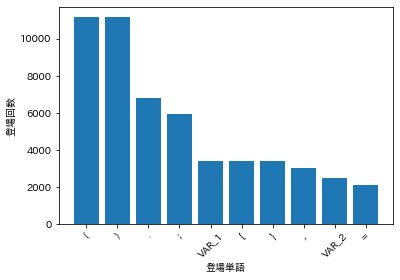

Most common words in data.target:


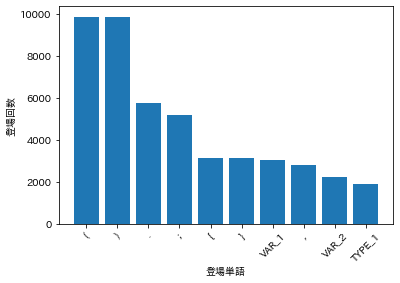

Most common words in gcbert.pred:


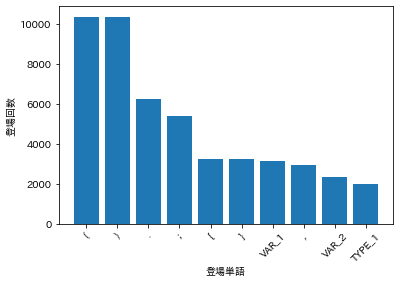

Most common words in codet5.pred:


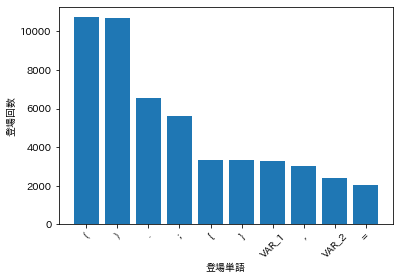

Most common words in codebert.pred:


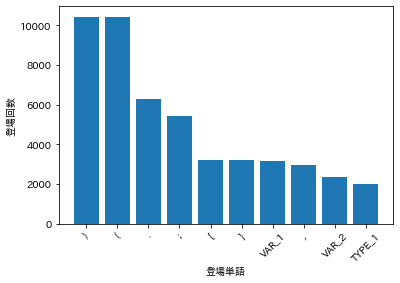

In [10]:
# output most common words in source, target, gcbert.pred, codet5.pred, codebert.pred and create histgram
COLUMNS = ["入力データでの", "出力データ", "gcbert予測", "codet5予測", "codebert予測"]
from collections import Counter
def most_common_words(df):
    for i, col in enumerate(["data.source", "data.target", "gcbert.pred", "codet5.pred", "codebert.pred"]):
        print(f"Most common words in {col}:")
        create_histgram(Counter(" ".join(df[col]).split(" ")), COLUMNS[i])
most_common_words(dfs) 

In [18]:
# add column that delete words between <START> and <END> from source
STARTTAG = "<START>"
ENDTAG = "<END>"
def delete_words_between_start_and_end(df):
    df["data.source_without_start_end"] = df["data.source"].apply(lambda x: x.replace(" ".join(x.split(" ")[x.split(" ").index(STARTTAG):x.split(" ").index(ENDTAG)+1]) + " ", ""))
    return df
dfs = delete_words_between_start_and_end(dfs)
print(dfs.loc[1,"data.source_without_start_end"])
print(dfs.loc[1, "data.source"])

public TYPE_8 ( TYPE_1 VAR_2 , TYPE_2 VAR_3 ) { this . VAR_4 = VAR_2 . METHOD_1 ( ) ; this . VAR_3 = VAR_3 ; }
public TYPE_8 ( TYPE_1 VAR_2 , TYPE_2 VAR_3 ) { this . VAR_4 = VAR_2 . METHOD_1 ( ) ; this . VAR_3 = VAR_3 ; <START> VAR_5 = VAR_6 . VAR_7 . TYPE_7 . METHOD_2 ( new TYPE_4 . TYPE_5 . action . TYPE_6 ( STRING_1 ) ) ; <END> }


In [31]:
# add column is same source without start and end and pred columns
def is_same_source_without_start_and_end_and_pred(df):
    for col in ["data.target", "gcbert.pred", "codet5.pred", "codebert.pred"]:
        df["is_same_delete_tag_" + col] = df["data.source_without_start_end"] == df[col]
        print("Sum of is_same_delete_tag_" + col + ": " + str(sum(df["is_same_delete_tag_" + col])))
    return df
dfs = is_same_source_without_start_and_end_and_pred(dfs)


Sum of is_same_delete_tag_data.target: 144
Sum of is_same_delete_tag_gcbert.pred: 55
Sum of is_same_delete_tag_codet5.pred: 44
Sum of is_same_delete_tag_codebert.pred: 57


In [35]:
# count is_same_delete_tag columns is true and data.target is also true
def count_is_same_delete_tag_and_target_true(df):
    for col in ["gcbert.pred", "codet5.pred", "codebert.pred"]:
        df["is_same_delete_tag_" + col + "_and_target_true"] = df["is_same_delete_tag_" + col] & df["is_same_delete_tag_data.target"]
        print("Sum of is_same_delete_tag_" + col + "_and_target_true: " + str(sum(df["is_same_delete_tag_" + col + "_and_target_true"])))
    return df
dfs = count_is_same_delete_tag_and_target_true(dfs)

Sum of is_same_delete_tag_gcbert.pred_and_target_true: 33
Sum of is_same_delete_tag_codet5.pred_and_target_true: 21
Sum of is_same_delete_tag_codebert.pred_and_target_true: 36


In [25]:
# 
IDENTIFIERS = ["private", "public", "static", "protect"]

def delete_identifier(df):
    
    df["delete_identifier"] = df["data.target"].apply(lambda x: x.replace("private", "").replace("public", "").replace("static", "").replace("private", ""))
    for col in ["data.target", "gcbert.pred", "codet5.pred", "codebert.pred"]:
        df["is_same_delete_identifier_" + col] = df["delete_identifier"] == df[col].apply(lambda x: x.replace("private ", "").replace("public ", "").replace("static ", "").replace("private ", ""))
        print("Sum of is_same_delete_identifier_" + col + ": " + str(sum(df["is_same_delete_identifier_" + col])))
    return df
dfs = delete_identifier(dfs)

Sum of is_same_delete_identifier_data.target: 238
Sum of is_same_delete_identifier_gcbert.pred: 34
Sum of is_same_delete_identifier_codet5.pred: 26
Sum of is_same_delete_identifier_codebert.pred: 31


In [37]:
# count is_same_delete_identifier columns is true and data.target is also true
def count_is_same_delete_identifier_and_target_true(df):
    for col in ["gcbert.pred", "codet5.pred", "codebert.pred"]:
        df["is_same_delete_identifier_" + col + "_and_target_true"] = df["is_same_delete_identifier_" + col] & df["is_same_delete_tag_data.target"]
        print("Sum of is_same_delete_identifier_" + col + "_and_target_true: " + str(sum(df["is_same_delete_identifier_" + col + "_and_target_true"])))
    return df
dfs = count_is_same_delete_identifier_and_target_true(dfs)

Sum of is_same_delete_identifier_gcbert.pred_and_target_true: 2
Sum of is_same_delete_identifier_codet5.pred_and_target_true: 3
Sum of is_same_delete_identifier_codebert.pred_and_target_true: 3


In [21]:
# output xls file
dfs.to_excel("./data/all.xls", index=False)

/var/folders/c0/b2qqsnx935n275qlt_fqz8300000gn/T/ipykernel_59622/2217403306.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  dfs.to_excel("./data/all.xls", index=False)


In [ ]:
# count